In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
from torch.utils.data import DataLoader, TensorDataset
import lightning as L
import torch.nn.functional as F
import optuna
import tensorboard
from lightning.pytorch.loggers import TensorBoardLogger

import warnings
warnings.filterwarnings("ignore")
from importlib import reload

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *

from sklearn.decomposition import PCA

In [3]:
# Path to your .gz file
file_path = 'data/hBreast/transcripts.csv.gz'

# Read the gzipped CSV file into a DataFrame
df_transcripts = pd.read_csv(file_path, compression='gzip')
df_transcripts.head(), df_transcripts.shape

(     transcript_id  cell_id  overlaps_nucleus feature_name  x_location  \
 0  281474976710657   191815                 1          LUM   4797.2383   
 1  281474976710663   214084                 1       SEC11C   4801.7330   
 2  281474976710672   191342                 0         TCIM   4804.4920   
 3  281474976710673   191574                 0         STC1   4805.0483   
 4  281474976710674   192193                 0         STC1   4805.7170   
 
    y_location  z_location         qv  
 0   550.61346   15.421524  18.445875  
 1   905.11600   14.925031  31.019386  
 2   596.05396   14.681485  22.270780  
 3   414.38370   19.306356  16.183300  
 4   273.81440   16.112896  26.251837  ,
 (43775350, 8))

In [4]:
df_transcripts = df_transcripts[~df_transcripts["feature_name"].str.startswith('BLANK_') & ~df_transcripts["feature_name"].str.startswith('NegControl')]

In [5]:
random_rows = df_transcripts.sample(n=10000, random_state=1)  # random_state is used for reproducibility

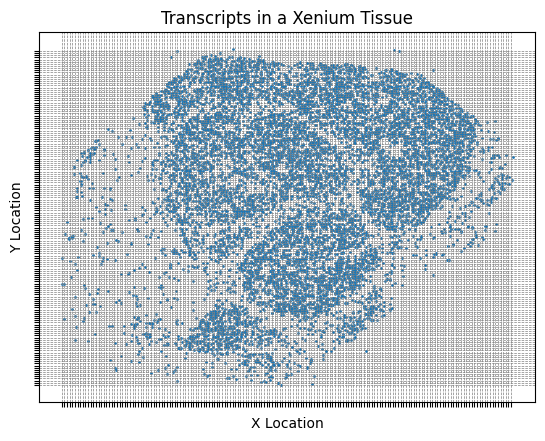

In [12]:
plt.scatter(random_rows["x_location"], random_rows["y_location"], s=1)
plt.xlabel('X Location')
plt.ylabel('Y Location')
plt.title('Transcripts in a Xenium Tissue')


k = 55
plt.xticks(range(int(random_rows["x_location"].min()), int(random_rows["x_location"].max()) + 1, k), labels=[])
plt.yticks(range(int(random_rows["y_location"].min()), int(random_rows["y_location"].max()) + 1, k), labels=[])

plt.grid(True, which='both', color='gray', linewidth=0.5, linestyle='--')

plt.show()

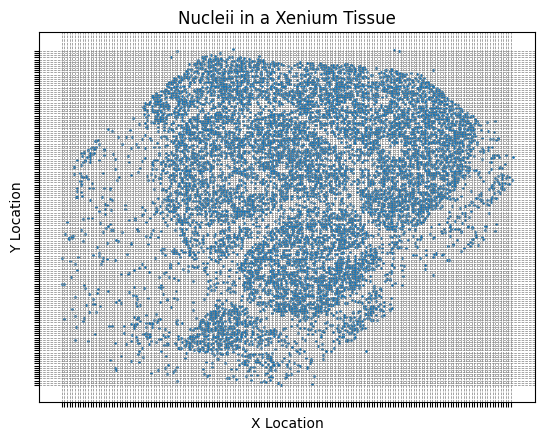

In [10]:
plt.scatter(random_rows["x_location"], random_rows["y_location"], s=1, c=random_rows["overlaps_nucleus"], cmap='viridis')
plt.colorbar(label='Feature Name')  # Adds a colorbar with labels to the plot
plt.xlabel('X Location')
plt.ylabel('Y Location')
plt.title('Nucleii in a Xenium Tissue')


k = 55
plt.xticks(range(int(random_rows["x_location"].min()), int(random_rows["x_location"].max()) + 1, k), labels=[])
plt.yticks(range(int(random_rows["y_location"].min()), int(random_rows["y_location"].max()) + 1, k), labels=[])

plt.grid(True, which='both', color='gray', linewidth=0.5, linestyle='--')

plt.show()

# EDA on Spot Data

For now, we will focus on the 2D case and ignore the 3D information.

In [13]:
clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
clustering.set_spot_size(100)
clustering.create_spot_data(third_dim=False, save_data=True)

In [14]:
valid_genes_mask = ~clustering.xenium_spot_data.var_names.str.startswith('BLANK_') & ~clustering.xenium_spot_data.var_names.str.startswith('NegControl')
clustering.xenium_spot_data = clustering.xenium_spot_data[:, valid_genes_mask]

In [15]:
clustering.normalize_counts(clustering.xenium_spot_data)

In [16]:
clustering.xenium_spot_data.obs

,spot_number,x_location,y_location,z_location,row,col
0,18,61.496516,1860.122953,11.994396,18.0,0.0
1,19,49.867141,1946.662950,11.948672,19.0,0.0
2,20,47.042232,2062.731100,11.884750,20.0,0.0
3,21,61.378934,2130.335117,11.876214,21.0,0.0
4,22,43.392587,2274.469092,12.102060,22.0,0.0
...,...,...,...,...,...,...
7307,9145,10212.948667,6793.102533,24.631090,67.0,102.0
7308,9146,10247.916375,6830.041012,24.520689,68.0,102.0
7309,9147,10248.615000,6923.818400,24.694735,69.0,102.0
7310,9231,10303.937000,6412.000000,24.712805,64.0,103.0


### PCA on Unfiltered Spot Data

In [17]:
sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack', n_comps=50)
clustering.xenium_spot_data.obsm["X_pca"]

array([[27.375328  , -5.864071  ,  2.0807905 , ...,  0.17618628,
         0.22874607,  0.14581062],
       [27.533068  , -6.075016  ,  2.1961548 , ...,  0.04162794,
         0.05065779, -0.05506336],
       [27.544216  , -5.892823  ,  2.3507462 , ..., -0.13419597,
         0.19031934, -0.03529169],
       ...,
       [28.225677  , -6.04525   ,  2.2492955 , ..., -0.03064303,
         0.13606103, -0.11833866],
       [28.218632  , -6.119332  ,  2.288882  , ..., -0.04828798,
         0.13532916, -0.09365143],
       [28.221315  , -6.1484747 ,  2.2884932 , ..., -0.07761873,
         0.12862208, -0.13375427]], dtype=float32)

In [18]:
clustering.xenium_spot_data.varm["PCs"]
clustering.xenium_spot_data.varm["PCs"]

array([[-0.08201569, -0.10246794,  0.00155436, ...,  0.0280475 ,
        -0.03695033, -0.00433225],
       [-0.07539996,  0.08549378, -0.0564924 , ...,  0.02994743,
         0.00168998, -0.01484693],
       [-0.06632275,  0.02272117, -0.02546248, ...,  0.02022079,
         0.0151507 , -0.03519609],
       ...,
       [-0.04725812,  0.08744886, -0.04181348, ...,  0.0892242 ,
         0.03976699,  0.08490759],
       [-0.04931512,  0.12792942, -0.0506216 , ..., -0.01878605,
        -0.05826849,  0.01520033],
       [-0.08442935, -0.0152686 , -0.00559765, ...,  0.00490379,
         0.01495373,  0.02659018]])

In [19]:
data = np.save('PC.npy', clustering.xenium_spot_data.varm["PCs"])

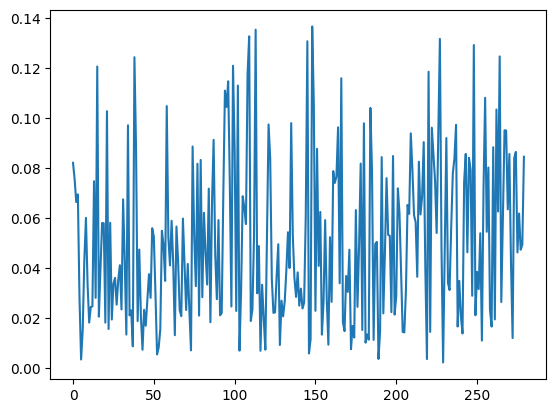

In [20]:
plt.plot(np.abs(clustering.xenium_spot_data.varm["PCs"][:, 0]))

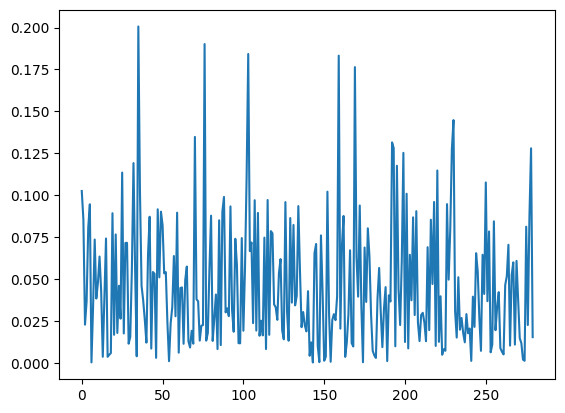

In [21]:
plt.plot(np.abs(clustering.xenium_spot_data.varm["PCs"][:, 1]))

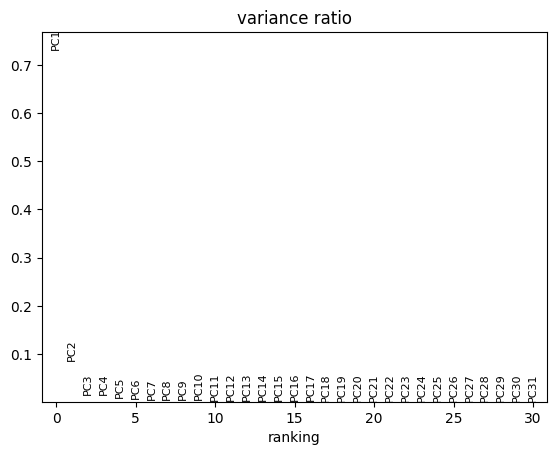

<Figure size 640x480 with 0 Axes>

In [22]:
sc.pl.pca_variance_ratio(clustering.xenium_spot_data)
plt.savefig("results/EDA/spotPCA.png")

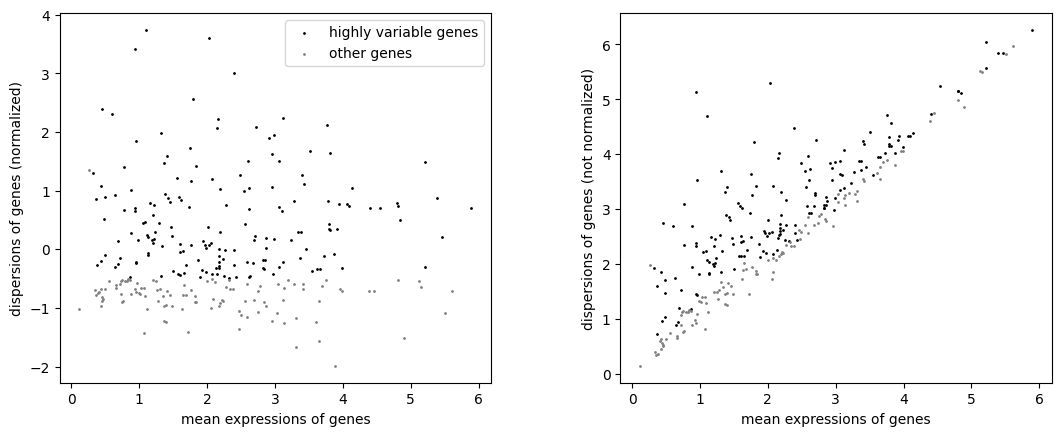

In [23]:
clustering.filter_only_high_variable_genes(clustering.xenium_spot_data, plot_highly_variable_genes=True)

### PCA on Highly-Variable Spot Data

In [24]:
clustering.xenium_spot_data = clustering.xenium_spot_data[:,clustering.xenium_spot_data.var.highly_variable==True]

sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack')
clustering.xenium_spot_data.obsm["X_pca"]

array([[ 2.1155056e+01, -5.4236507e+00,  2.0466990e+00, ...,
         3.9729184e-01, -8.3824076e-02, -2.0354150e-01],
       [ 2.1070641e+01, -5.6439409e+00,  2.1660337e+00, ...,
        -1.1177375e-01,  3.9777905e-03,  5.1005155e-02],
       [ 2.0890097e+01, -5.5450473e+00,  2.1540532e+00, ...,
         2.9742104e-01,  1.2235555e-01,  7.8696674e-03],
       ...,
       [ 2.1647491e+01, -5.6506290e+00,  2.1944153e+00, ...,
         3.3974978e-01,  5.0348636e-02, -2.5710562e-01],
       [ 2.1715868e+01, -5.7138386e+00,  2.2376385e+00, ...,
         3.2959709e-01,  4.0335078e-02, -2.2141641e-01],
       [ 2.1642092e+01, -5.7624626e+00,  2.2334089e+00, ...,
         3.3015153e-01,  5.9149377e-02, -2.2588079e-01]], dtype=float32)

In [25]:
clustering.xenium_spot_data.varm["PCs"]

array([[-0.10699564, -0.11410391,  0.00117439, ..., -0.03022742,
        -0.01986326,  0.01722844],
       [-0.0986475 ,  0.09119226, -0.06235806, ...,  0.01464726,
         0.01444651, -0.05148864],
       [-0.08648925,  0.02269415, -0.02386993, ..., -0.0395036 ,
         0.00219862, -0.05452655],
       ...,
       [-0.10936521, -0.0045643 , -0.06428538, ...,  0.01780843,
        -0.02518753,  0.03106353],
       [-0.06078764,  0.08463245, -0.05683716, ..., -0.11386029,
         0.00363337, -0.07797775],
       [-0.06466508,  0.1365315 , -0.05529846, ...,  0.03566939,
        -0.00137214, -0.00676752]])

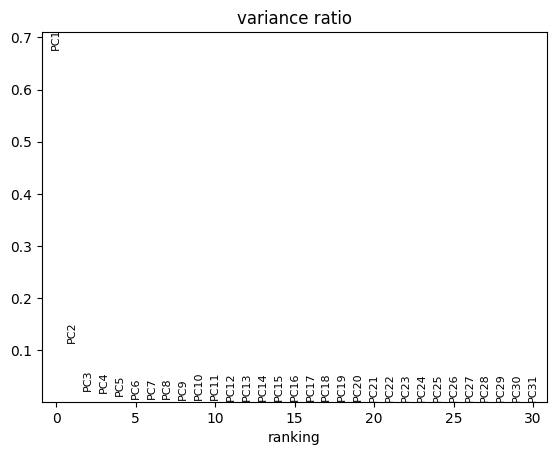

In [26]:
sc.pl.pca_variance_ratio(clustering.xenium_spot_data)

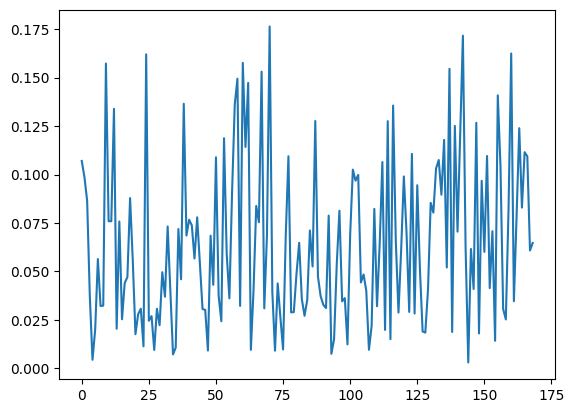

In [27]:
plt.plot(np.abs(clustering.xenium_spot_data.varm["PCs"][:, 0]))

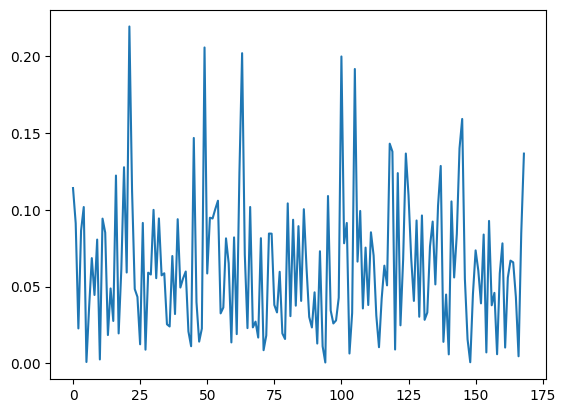

In [28]:
plt.plot(np.abs(clustering.xenium_spot_data.varm["PCs"][:, 1]))

In [29]:
clustering.xenium_spot_data.var

,highly_variable,means,dispersions,dispersions_norm
ABCC11,True,2.953047,3.744833,1.633337
ACTA2,True,3.785395,4.306623,0.821881
ACTG2,True,2.702556,3.293917,0.228456
ADGRE5,True,1.497032,1.916026,-0.362325
ADH1B,True,2.189261,3.317184,1.025289
...,...,...,...,...
TRIB1,True,2.911854,3.839642,1.891252
TUBA4A,True,3.123837,3.380066,-0.212255
USP53,True,3.544375,3.630508,-0.375634
VWF,True,2.611254,3.533479,0.686099


# EDA on Cell Data

In [30]:
cells = df_transcripts.groupby(['cell_id', 'feature_name']).size().reset_index(name='count')
cells_pivot = cells.pivot_table(index='cell_id', 
                                columns='feature_name', 
                                values='count', 
                                fill_value=0)
cells_pivot.shape

(356743, 280)

In [31]:
location_means = df_transcripts.groupby('cell_id').agg({
    'x_location': 'mean',
    'y_location': 'mean',
    'z_location': 'mean'
}).reset_index()

cells_pivot = location_means.join(cells_pivot, on='cell_id')

In [32]:
# log normalization
cells_pivot.iloc[:, 4:] = np.log1p(cells_pivot.iloc[:, 4:])

In [33]:
cells_pivot = cells_pivot[cells_pivot["cell_id"] != -1]

In [34]:
cells_pivot.head()

,cell_id,x_location,y_location,z_location,ABCC11,ACTA2,ACTG2,ADAM9,ADGRE5,ADH1B,...,TUBA4A,TUBB2B,UCP1,USP53,VOPP1,VWF,WARS,ZEB1,ZEB2,ZNF562
1,1,1587.163466,1683.353685,15.503466,0.0,1.098612,0.000000,0.693147,0.000000,2.302585,...,0.000000,0.693147,0.0,1.791759,0.000000,0.000000,0.000000,0.693147,1.098612,0.000000
2,2,1650.407270,1514.410011,14.617333,0.0,0.000000,0.000000,0.693147,1.098612,0.693147,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.693147,2.197225,0.693147
3,3,1645.398455,1703.216616,16.257603,0.0,0.693147,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,1664.134134,1506.358351,14.915675,0.0,1.386294,0.693147,0.000000,0.000000,1.386294,...,1.609438,0.000000,0.0,1.609438,0.693147,2.302585,1.609438,0.000000,1.609438,0.693147
5,5,1656.013911,1655.548640,16.786045,0.0,0.000000,0.000000,1.098612,0.000000,1.098612,...,0.000000,0.000000,0.0,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [67]:
random_cells = cells_pivot.sample(n=10000, random_state=1)  # random_state is used for reproducibility

In [68]:
int(random_cells["x_location"].min()), int(random_cells["x_location"].max())


(572, 10017)

In [69]:
int(random_cells["y_location"].min()), int(random_cells["y_location"].max())

(131, 8471)

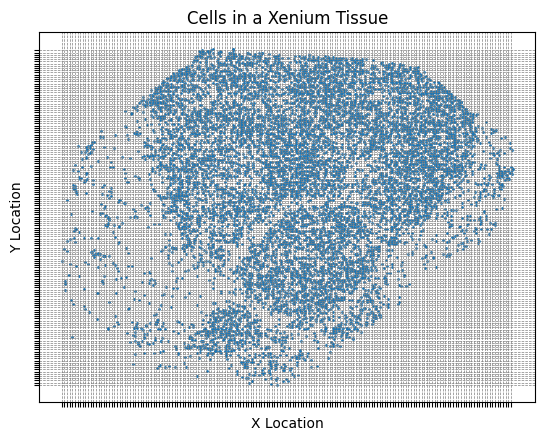

In [70]:
plt.scatter(random_cells["x_location"], random_cells["y_location"], s=1)
plt.xlabel('X Location')
plt.ylabel('Y Location')
plt.title('Cells in a Xenium Tissue')


k = 55
plt.xticks(range(int(random_cells["x_location"].min()), int(random_cells["x_location"].max()) + 1, k), labels=[])
plt.yticks(range(int(random_cells["y_location"].min()), int(random_cells["y_location"].max()) + 1, k), labels=[])

plt.grid(True, which='both', color='gray', linewidth=0.5, linestyle='--')

plt.savefig("results/EDA/cells.png")

plt.show()

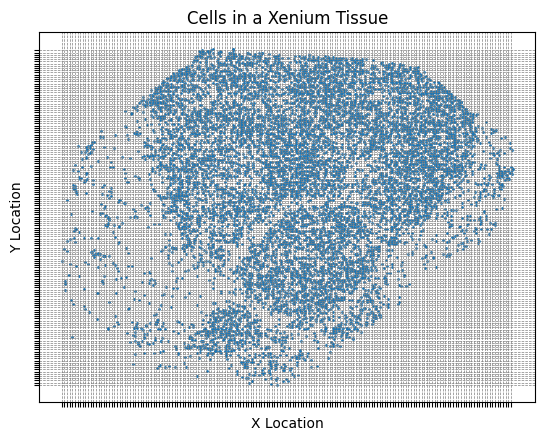

In [71]:
plt.scatter(random_cells["x_location"], random_cells["y_location"], s=1)
plt.xlabel('X Location')
plt.ylabel('Y Location')
plt.title('Cells in a Xenium Tissue')


k = 55
plt.xticks(range(int(random_cells["x_location"].min()), int(random_cells["x_location"].max()) + 1, k), labels=[])
plt.yticks(range(int(random_cells["y_location"].min()), int(random_cells["y_location"].max()) + 1, k), labels=[])

plt.grid(True, which='both', color='gray', linewidth=0.5, linestyle='--')

plt.savefig("results/EDA/cells.png")

plt.show()

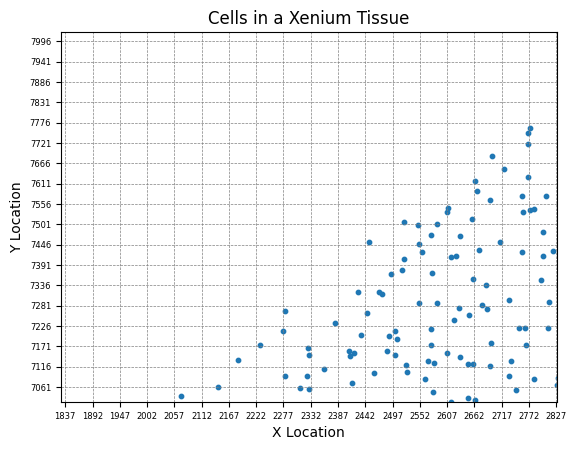

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'random_cells' is your DataFrame and it contains 'x_location' and 'y_location'

# Create scatter plot
plt.scatter(random_cells["x_location"], random_cells["y_location"], s=10)
plt.xlabel('X Location')
plt.ylabel('Y Location')
plt.title('Cells in a Xenium Tissue')

# Define the grid interval
k = 55
plt.xticks(range(int(random_cells["x_location"].min()), int(random_cells["x_location"].max()) + 1, k), fontsize=6)
plt.yticks(range(int(random_cells["y_location"].min()), int(random_cells["y_location"].max()) + 1, k), fontsize=6)

# Set gridlines
plt.grid(True, which='both', color='gray', linewidth=0.5, linestyle='--')

# Define the zoom area size
zoom_size = 1000  # Define how large the zoom area should be

# Select a random center point for the zoom
center_x = np.random.randint(2100, 2500)
center_y = np.random.randint(7000, random_cells["y_location"].max())

# Set the limits for the zoom area
plt.xlim(center_x - zoom_size / 2, center_x + zoom_size / 2)
plt.ylim(center_y - zoom_size / 2, center_y + zoom_size / 2)

plt.savefig("results/EDA/zoomed_cells.png")

# Show the plot with zoomed area
plt.show()


In [73]:
pca = PCA(n_components=20)
pca.fit(cells_pivot.iloc[:, 4:])

PCA(n_components=20)

In [ ]:
np.set_printoptions(suppress=True)
print(np.round(pca.explained_variance_ratio_, 4))

[0.2441 0.06   0.0273 0.0232 0.0198 0.0174 0.012  0.0115 0.0109 0.0097
 0.0093 0.0086 0.008  0.0076 0.0074 0.007  0.0069 0.0066 0.0065 0.0064]


In [43]:
cells_pivot.head()

,cell_id,x_location,y_location,z_location,ABCC11,ACTA2,ACTG2,ADAM9,ADGRE5,ADH1B,...,TUBA4A,TUBB2B,UCP1,USP53,VOPP1,VWF,WARS,ZEB1,ZEB2,ZNF562
1,1,1587.163466,1683.353685,15.503466,0.0,1.098612,0.000000,0.693147,0.000000,2.302585,...,0.000000,0.693147,0.0,1.791759,0.000000,0.000000,0.000000,0.693147,1.098612,0.000000
2,2,1650.407270,1514.410011,14.617333,0.0,0.000000,0.000000,0.693147,1.098612,0.693147,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.693147,2.197225,0.693147
3,3,1645.398455,1703.216616,16.257603,0.0,0.693147,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,1664.134134,1506.358351,14.915675,0.0,1.386294,0.693147,0.000000,0.000000,1.386294,...,1.609438,0.000000,0.0,1.609438,0.693147,2.302585,1.609438,0.000000,1.609438,0.693147
5,5,1656.013911,1655.548640,16.786045,0.0,0.000000,0.000000,1.098612,0.000000,1.098612,...,0.000000,0.000000,0.0,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [44]:
genes = cells_pivot.iloc[:, 4:]
gene_dispersions = genes.var(axis=0) / (genes.mean(axis=0) ** 2)
gene_dispersions.sort_values(ascending=False)

PDCD1      405.738909
S100A8     290.419181
GNLY       209.690382
CTSG       157.251466
CD19       146.190599
              ...    
TACSTD2      0.377248
KRT7         0.347036
TOMM7        0.341501
TPD52        0.331611
GATA3        0.298791
Length: 280, dtype: float64

In [45]:
gene_dispersions_proportions = (gene_dispersions / sum(gene_dispersions)).sort_values(ascending=False)
gene_dispersions_proportions

PDCD1      0.054154
S100A8     0.038762
GNLY       0.027987
CTSG       0.020988
CD19       0.019512
             ...   
TACSTD2    0.000050
KRT7       0.000046
TOMM7      0.000046
TPD52      0.000044
GATA3      0.000040
Length: 280, dtype: float64

In [46]:
gene_dispersions_proportions.cumsum()

PDCD1      0.054154
S100A8     0.092916
GNLY       0.120903
CTSG       0.141892
CD19       0.161404
             ...   
TACSTD2    0.999824
KRT7       0.999870
TOMM7      0.999916
TPD52      0.999960
GATA3      1.000000
Length: 280, dtype: float64

In [47]:
gene_dispersions_proportions[(gene_dispersions_proportions.cumsum() < 0.65)].index, len(gene_dispersions_proportions[(gene_dispersions_proportions.cumsum() < 0.65)].index)

(Index(['PDCD1', 'S100A8', 'GNLY', 'CTSG', 'CD19', 'OPRPN', 'TCL1A', 'KRT5',
        'UCP1', 'NCAM1', 'KRT6B', 'CEACAM8', 'CD79B', 'LILRA4', 'IL2RA', 'GZMK',
        'CD79A', 'MUC6', 'SCGB2A1', 'NDUFA4L2', 'MMP12', 'SPIB', 'CD80', 'NKG7',
        'LTB', 'MMP1', 'MZB1', 'CCL8', 'AVPR1A', 'PRF1', 'ESM1', 'TNFRSF17',
        'MS4A1', 'APOBEC3A', 'TIMP4', 'ADIPOQ', 'CCR7', 'CXCL5', 'HPX', 'FOXC2',
        'SNAI1', 'TPSAB1', 'SOX18', 'CLECL1', 'PDCD1LG2', 'FOXP3', 'CTLA4',
        'C5orf46', 'LAG3', 'CLEC9A', 'CD27', 'BANK1', 'HOXD9', 'IL3RA', 'KLRD1',
        'AQP3'],
       dtype='object'),
 56)

In [48]:
gene_variances = genes.var(axis=0)
gene_variances = gene_variances.sort_values(ascending=False)
gene_var_proportions = (gene_variances / sum(gene_variances))
gene_var_proportions

GATA3       0.025460
SCD         0.024311
SERPINA3    0.024099
KRT7        0.022723
TACSTD2     0.021950
              ...   
UCP1        0.000116
OPRPN       0.000111
CD19        0.000105
S100A8      0.000089
PDCD1       0.000034
Length: 280, dtype: float64

In [49]:
gene_var_proportions.cumsum()

GATA3       0.025460
SCD         0.049771
SERPINA3    0.073870
KRT7        0.096593
TACSTD2     0.118544
              ...   
UCP1        0.999661
OPRPN       0.999772
CD19        0.999877
S100A8      0.999966
PDCD1       1.000000
Length: 280, dtype: float64

In [50]:
gene_var_proportions[(gene_var_proportions.cumsum() < 0.95)].index, len(gene_dispersions_proportions[(gene_var_proportions.cumsum() < 0.95)].index)

(Index(['GATA3', 'SCD', 'SERPINA3', 'KRT7', 'TACSTD2', 'TPD52', 'KRT23',
        'FOXA1', 'CCND1', 'ANKRD30A',
        ...
        'PRDM1', 'CYTIP', 'EGFR', 'KDR', 'AKR1C1', 'FCER1A', 'OXTR', 'CD163',
        'IL2RG', 'SSTR2'],
       dtype='object', length=176),
 176)